In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from time import time
from tqdm import trange
from scipy.stats import *

Model is
$$ 
\left ( 1 - \sum_{i=1}^p \phi_i B^i \right ) y_t 
=
\left ( 1 + \sum_{j=1}^q \theta_j B^j \right ) (1-B)^{-d} \varepsilon_t  + \beta^\top X_t,
$$
where $\{X_t\}_{t \geq 0}$ are some known covariates and $\{\varepsilon_t\}_{t \geq 0}$ is white noise.

Now let 
\begin{align}
Z_t 
= 
(1-B)^{-d} \varepsilon_t = \left (\sum_{k=0}^\infty b_k B^k \right ) \varepsilon_t 
& =
b_0 \varepsilon_{t-0} + b_1 \varepsilon_{t-1} + \cdots + b_t \varepsilon_{t-t}
= 
b_0 \varepsilon_t + b_1 \varepsilon_{t-1} + \cdots + b_t \varepsilon_0. 
\end{align}

Then the model reduces down to 
\begin{align}
y_t - \sum_{i=1}^p \phi_i y_{t-i}
& = 
Z_t + \sum_{j=1}^q \theta_q Z_{t-j} + \beta^\top X_t,
\\
Z_t 
& = 
\sum_{k=0}^{t} b_k \varepsilon_{t-k}, \quad \varepsilon_k \stackrel{\text{i.i.d.}}{\sim} \mathrm{N}(0,1)
\end{align}

In [86]:
d = 1/3
T = 10**5
eps = npr.randn(T)
b = np.zeros(T)
for j in np.arange(0,150) :
    b[j] = math.gamma(j+d)/(math.gamma(j+1)*math.gamma(d))
for j in np.arange(150,T) :
    b[j] = j**(d-1)/math.gamma(d)

In [87]:
Z = np.zeros(T)
for t in trange(T) :
    Z[t] = np.sum(b[:t]*(eps[:t][::-1]))

100%|██████████| 100000/100000 [00:09<00:00, 10952.61it/s]


In [89]:
p = 5
q = 5
r = max(p,q)
phi = npr.randn(p)/3
theta = npr.randn(q)/3

d = 50
beta = npr.randn(d)
X = npr.rand(d,T)/5

y = np.zeros(T)
for t in np.arange(0,r) :
    y[t] = beta.dot(X[:,t]) + npr.randn()
for t in np.arange(r,T) :
    y[t] = beta.dot(X[:,t]) + np.sum(phi*y[(t-p):t]) + Z[t] + np.sum(theta*Z[(t-q):t])

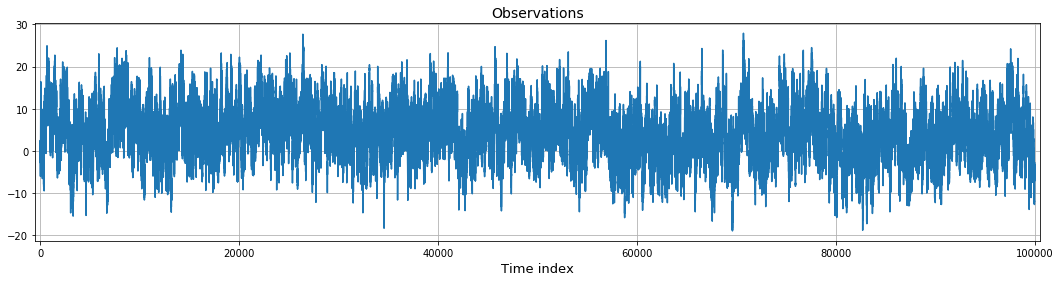

In [90]:
plt.figure(figsize=(18,4))
plt.plot(y)
plt.xlim(-0.005*T,1.005*T)
plt.title("Observations", fontsize=14)
plt.xlabel("Time index", fontsize=13)
plt.grid(True);

In [91]:
def acf(y, maxlag) :
    T = len(y)
    assert maxlag < T-10
    acfs = np.zeros(maxlag+1)
    for lag in trange(maxlag+1) :
        y1 = y[0:(T-lag)]
        y2 = y[lag:T]
        acfs[lag] = (np.mean(y1*y2) - np.mean(y1)*np.mean(y2))/(np.std(y1)*np.std(y2))
    return acfs

100%|██████████| 10001/10001 [00:06<00:00, 1475.95it/s]


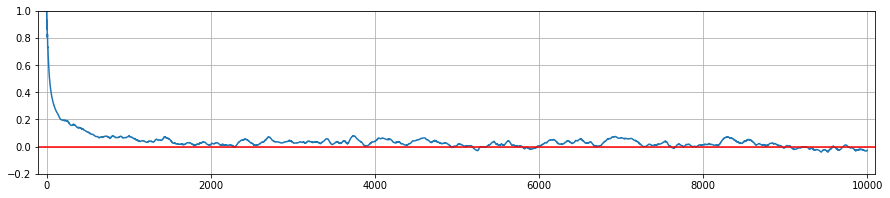

In [99]:
maxlag = 10_000
acfs_y = acf(y,maxlag)
plt.figure(figsize=(15,3))
plt.plot(acfs_y)
plt.grid(True)
plt.ylim(-0.2,1)
plt.axhline(y=0, color="red")
plt.xlim(-0.01*maxlag,1.01*maxlag);